<h1 style="font-size: 30px; color:orange;">Convolutional Autoencoder (CAE) on the MNIST-Dataset using Tensorflow</h1>
<h2 style="font-size: 20px;">Authors: Bruno Figura & Daniel Labuda, ML II Projektarbeit Gruppe 2, SoSe24</h2>
-----------------------------------------------------------------------------------------------------


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns

from keras.datasets import mnist
import tensorflow as tf
from keras.models import Model
from keras import layers, models, Input
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

Split the imported dataset into training and test data. Preprocess (reshape and normalize) the dataset. Print out the shapes of the resulting tensors.

Training data shape:
 (60000, 28, 28, 1) 

Test data shape:
 (10000, 28, 28, 1) 

Training labels shape:
 (60000, 10) 

Test labels shape:
 (10000, 10)


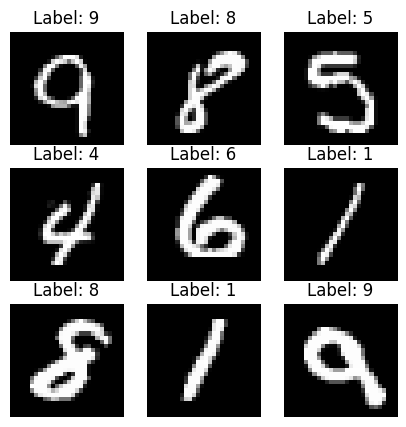

In [5]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

print("Training data shape:\n", train_data.shape, "\n")
print("Test data shape:\n", test_data.shape, "\n")
print("Training labels shape:\n", train_labels.shape, "\n")
print("Test labels shape:\n", test_labels.shape)

random_indices = np.random.choice(train_data.shape[0], 9, replace=False)
random_digits = train_data[random_indices]

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_digits[i], cmap='gray')
    plt.title(f"Label: {np.argmax(train_labels[random_indices[i]])}")
    plt.axis('off')
plt.show()

Define the CNN-Autoencoder (CAE) model

In [11]:
# Encoder
input_img = Input(shape=(28, 28, 1))

# 1st convolution layer
x = layers.Conv2D(4, (5, 5), padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# 2nd convolution layer
x = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(x)
encoded = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(encoded)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(4, (5, 5), padding='same', activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (5, 5), padding='same', activation='sigmoid')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded)

# Classifier on top of Encoder
x = layers.Flatten()(encoded)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)

# Full model including classifier
full_model = Model(input_img, output)

autoencoder.summary()
full_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 16)     │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 4)      │         1,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 1)      │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,841 (38.44 KB)

 Trainable params: 9,841 (38.44 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 16)     │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,106 (434.01 KB)

 Trainable params: 111,106 (434.01 KB)

 Non-trainable params: 0 (0.00 B)

Compile and train the previously defined architecture on the preprocessed dataset.

In [7]:
# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(train_data, train_data, batch_size=128, epochs=200, validation_data=(test_data, test_data))

# Compile and train the full model
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
full_model.fit(train_data, train_labels, batch_size=128, epochs=200, validation_data=(test_data, test_labels))

#model.save('C:/Users/AL/Desktop/Machine Learning II Thema 2/model_mnist.keras')


Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.2662 - val_loss: 0.0910
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0893 - val_loss: 0.0830
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0822 - val_loss: 0.0788
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0792 - val_loss: 0.0772
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0772 - val_loss: 0.0754
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0762 - val_loss: 0.0751
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0752 - val_loss: 0.0737
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0744 - val_loss: 0.0732
Epoch 9/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0739 - val_loss: 0.0727
Epoch 10/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0733 - val_loss: 0.0723
Epoch 11/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0729 - val_loss: 0.0719
Epoch 12/200
469/469 ━━━━━━━━

Plot 5 random input-images to be ran through the CAE aswell as the results.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


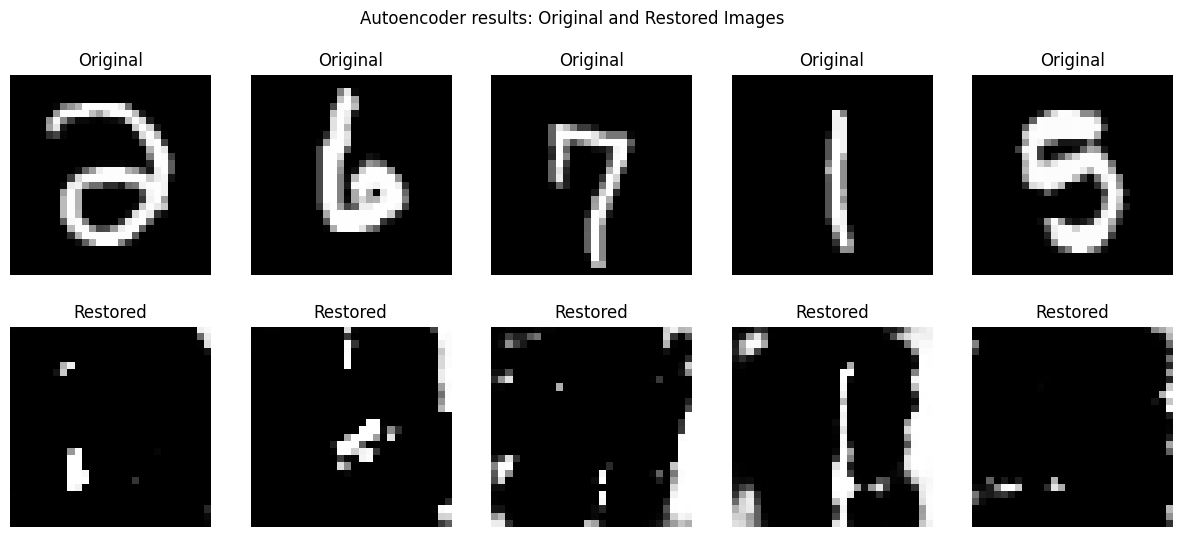

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


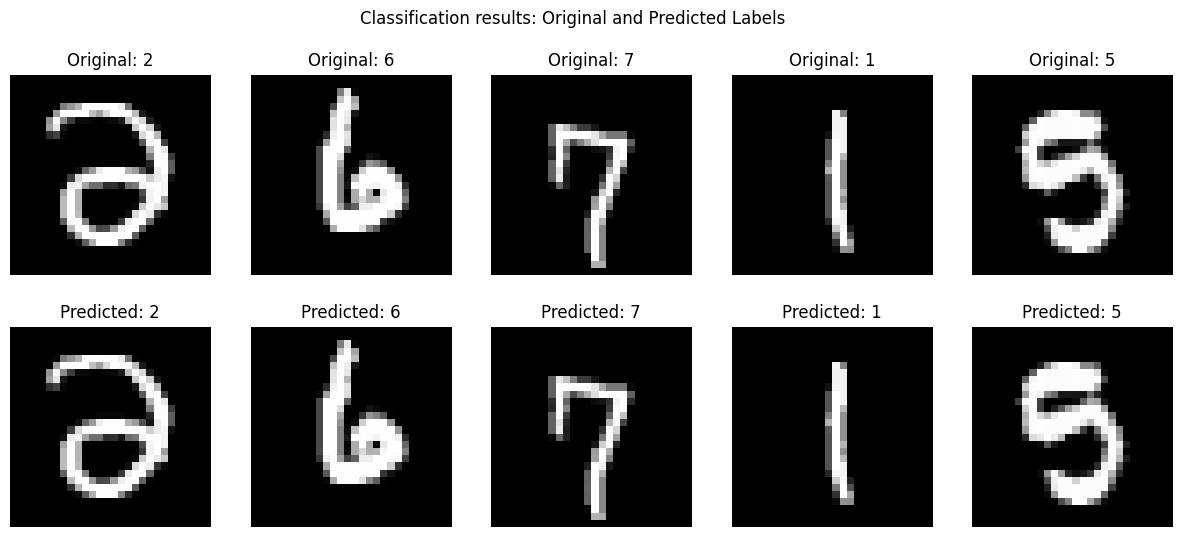

In [8]:
# Select 5 random test images
num_samples = test_data.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Get the restored images from the autoencoder
restored_imgs = autoencoder.predict(test_data)

# Create a 2x5 grid for displaying results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Autoencoder results: Original and Restored Images')

for i in range(5):
    random_index = indices[i]

    # Original images
    axes[0, i].imshow(test_data[random_index].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Restored images
    axes[1, i].imshow(restored_imgs[random_index].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Restored')

plt.show()

# Get predictions from the classifier
predictions = full_model.predict(test_data)

# Display classification results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Classification results: Original and Predicted Labels')

for i in range(5):
    random_index = indices[i]

    # Original images
    axes[0, i].imshow(test_data[random_index].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original: {np.argmax(test_labels[random_index])}')

    # Predicted labels
    axes[1, i].imshow(test_data[random_index].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Predicted: {np.argmax(predictions[random_index])}')

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


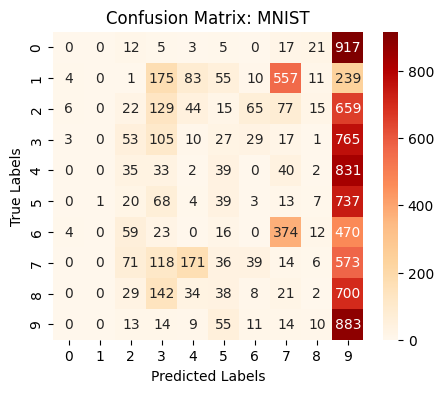

Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       980
           1      0.000     0.000     0.000      1135
           2      0.070     0.021     0.033      1032
           3      0.129     0.104     0.115      1010
           4      0.006     0.002     0.003       982
           5      0.120     0.044     0.064       892
           6      0.000     0.000     0.000       958
           7      0.012     0.014     0.013      1028
           8      0.023     0.002     0.004       974
           9      0.130     0.875     0.227      1009

    accuracy                          0.107     10000
   macro avg      0.049     0.106     0.046     10000
weighted avg      0.048     0.107     0.046     10000



In [12]:
# Predict the labels for the test data
predicted_labels = np.argmax(full_model.predict(test_data), axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: MNIST')
plt.show()

report = classification_report(true_labels, predicted_labels, digits=3)
print('Classification Report:\n', report)
